In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline

In [9]:
houses = sklearn.datasets.fetch_california_housing('../data')
data = pd.DataFrame(houses.data, columns=houses.feature_names)
data = data.assign(Price = houses.target)
cols = list(data.columns)
cols.remove('Price')
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
std = data.describe().loc['mean':'std',:]
for col in cols:
    data[col] = (data[col]-std[col]['mean'])/std[col]['std']

In [11]:
logflag = False
if logflag == True:
    data['Price'] = np.log(data['Price'])

In [12]:
data = data.assign(Bias = 1)
data = data[['Bias'] + cols + ['Price']]
data.head()

,Bias,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,1,2.344709,0.982119,0.628544,-0.153754,-0.974405,-0.049595,1.052523,-1.327803,4.526
1,1,2.332181,-0.607004,0.327033,-0.263329,0.861418,-0.092510,1.043159,-1.322812,3.585
2,1,1.782656,1.856137,1.155592,-0.049015,-0.820757,-0.025842,1.038478,-1.332794,3.521
3,1,0.932945,1.856137,0.156962,-0.049832,-0.766010,-0.050328,1.038478,-1.337785,3.413
4,1,-0.012881,1.856137,0.344702,-0.032905,-0.759828,-0.085614,1.038478,-1.337785,3.422


In [13]:
train, test = train_test_split(data, test_size=0.25)

batch_size = 100
train = torch.utils.data.DataLoader(dataset=torch.Tensor(train.values), batch_size=batch_size, shuffle=False)
test = torch.utils.data.DataLoader(dataset=torch.Tensor(test.values), batch_size=batch_size, shuffle=False)
w = Variable(torch.Tensor(len(cols)+1).uniform_(), requires_grad=True)

In [14]:
def forward(x):
    return torch.mm(x, w.view(-1,1))

def loss(x, y, exponentiate_prediction = False):
    prediction = torch.exp(forward(x)) if exponentiate_prediction == True else forward(x)
    return ((y - prediction) ** 2).mean()

In [15]:
pause = '\n'
losses = []
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.3f}'.format})
learning_rate = 1e-4
for epoch in range(0,201):
    for index, batch in enumerate(train, 0):
        x = batch[:,:-1]
        y = batch[:,-1]
        l = loss(x, y)
        l.backward()
        # print('\tweights: ', w.data.cpu().numpy())
        # print('\tgradient: ', w.grad.data.cpu().numpy())
        w.data = w.data - learning_rate * w.grad.data
        w.grad.data.zero_()
        # input(pause)
    losses.append(l)
    if epoch % 10 == 0:
        print('epoch:', epoch, l.data)

epoch: 0 tensor(3.6541)
epoch: 10 tensor(2.3511)
epoch: 20 tensor(1.7792)
epoch: 30 tensor(1.5076)
epoch: 40 tensor(1.3727)
epoch: 50 tensor(1.3044)
epoch: 60 tensor(1.2696)
epoch: 70 tensor(1.2521)
epoch: 80 tensor(1.2435)
epoch: 90 tensor(1.2392)
epoch: 100 tensor(1.2372)
epoch: 110 tensor(1.2363)
epoch: 120 tensor(1.2357)
epoch: 130 tensor(1.2353)
epoch: 140 tensor(1.2349)
epoch: 150 tensor(1.2345)
epoch: 160 tensor(1.2341)
epoch: 170 tensor(1.2336)
epoch: 180 tensor(1.2330)
epoch: 190 tensor(1.2325)
epoch: 200 tensor(1.2319)


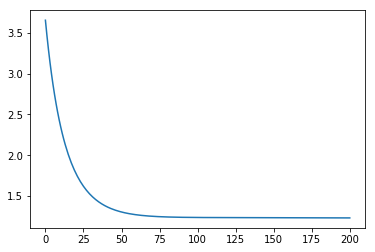

In [16]:
plt.plot(losses);

In [18]:
if logflag == True:
    print('mean loss for log: ', loss(test.dataset[:,:-1],(test.dataset[:,-1]), True).mean().data.numpy())
else:
    print('mean loss: ', loss(test.dataset[:,:-1],test.dataset[:,-1]).mean().data.numpy())

mean loss:  1.3285686


***

In [19]:
girth = 14
sample = test.dataset[torch.randperm(test.dataset.size(0))[:girth]]
x = sample[:,:-1]
y = sample[:,-1]
r = torch.Tensor(x.size(1)).uniform_()
result = pd.DataFrame()
result = result.assign(predicted = forward(x).view(1,-1).detach().numpy()[0])
result = result.assign(expected = y.numpy())
result = result.assign(random = torch.mv(x, r).numpy())
result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
predicted,2.113753,1.906858,2.249956,2.248877,2.217803,1.917841,2.097530,2.061664,1.980256,2.057099,2.046047,2.412630,2.135172,2.039695
expected,4.442000,2.190000,1.674000,2.019000,0.923000,0.764000,0.513000,1.176000,2.357000,0.857000,1.125000,1.238000,1.469000,3.908000
random,0.655103,0.292957,1.127155,1.325338,0.846193,0.239573,0.788535,0.550576,0.016226,0.823005,0.415803,2.966288,0.761598,0.497815
